In [90]:
import os
import imageio
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical

In [68]:
def load_dataset(target_size):
    x, y = [], []
    base_path = "./data/images/"

    for dir in os.listdir(base_path):
        for image in os.listdir(os.path.join(base_path, dir)):
            image_path = os.path.join(base_path, dir, image)
            image = Image.open(image_path)
            rgb_image = image.copy().convert("RGB")
            x.append(np.array(rgb_image.resize(target_size), dtype=np.uint8))
            y.append(dir)

    return x, y

In [69]:
target_size = (224, 224)

In [70]:
metadata = pd.read_csv("./data/metadata.csv")
meta_filter = metadata[["Channel", "Category"]]
meta_filter = meta_filter.drop_duplicates()
meta_dict = meta_filter.set_index("Channel")["Category"].to_dict()

In [96]:
x, y = load_dataset(target_size)

class: Abroad in Japan


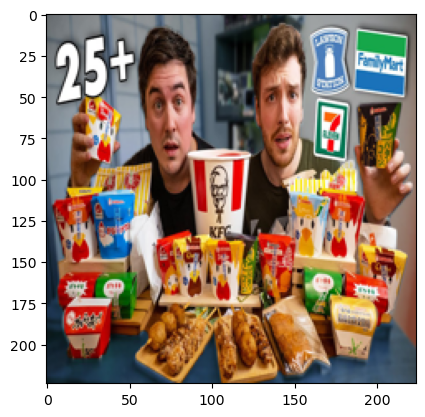

In [97]:
plt.imshow(x[100])
print(f"class: {y[100]}")

In [98]:
y = [meta_dict[item] for item in y]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2, random_state=42)
num_classes = len(set(y))

x_train = np.array(x_train)
x_test = np.array(x_test)

print(f"Train size: {len(y_train)} --- Test size: {len(y_test)}")

Train size: 1842 --- Test size: 461


In [20]:
base_path = os.getcwd()
data_path = os.path.join(base_path, "data")

train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [23]:
for i in range(len(x_train)):
    img_name = f"train_{i}.png"
    img_path = os.path.join(train_dir, img_name)
    imageio.imwrite(img_path, x_train[i])

for i in range(len(x_test)):
    img_name = f"test_{i}.png"
    img_path = os.path.join(test_dir, img_name)
    imageio.imwrite(img_path, x_test[i])

In [100]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [101]:
train_generator = train_datagen.flow(
    x_train,
    y_train, 
    batch_size=32,
    shuffle=True
)

test_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=32,
    shuffle=False
)

In [82]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=target_size+(3,))

In [85]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [86]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10
58/58 [==============================] - 107s 2s/step - loss: 2.8069 - accuracy: 0.3100 - val_loss: 2.3132 - val_accuracy: 0.3427
Epoch 2/10
58/58 [==============================] - 106s 2s/step - loss: 1.7287 - accuracy: 0.4756 - val_loss: 2.1370 - val_accuracy: 0.3970
Epoch 3/10
58/58 [==============================] - 108s 2s/step - loss: 1.4983 - accuracy: 0.5320 - val_loss: 2.1488 - val_accuracy: 0.3926
Epoch 4/10
58/58 [==============================] - 105s 2s/step - loss: 1.2833 - accuracy: 0.6042 - val_loss: 1.9809 - val_accuracy: 0.4360
Epoch 5/10
58/58 [==============================] - 107s 2s/step - loss: 1.1542 - accuracy: 0.6406 - val_loss: 1.9454 - val_accuracy: 0.4403
Epoch 6/10
58/58 [==============================] - 108s 2s/step - loss: 1.0042 - accuracy: 0.6857 - val_loss: 2.0625 - val_accuracy: 0.4469
Epoch 7/10
58/58 [==============================] - 108s 2s/step - loss: 0.9278 - accuracy: 0.7188 - val_loss: 2.1120 - val_accuracy: 0.4295
Epoch 8/10
58

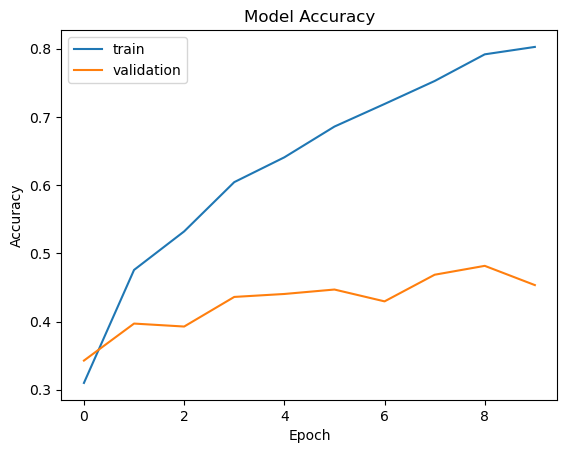

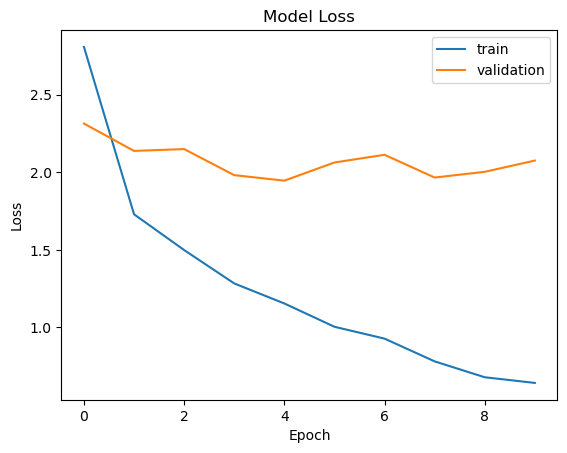

In [87]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

15/15 [==============================] - 18s 1s/step
Accuracy of 9.33%


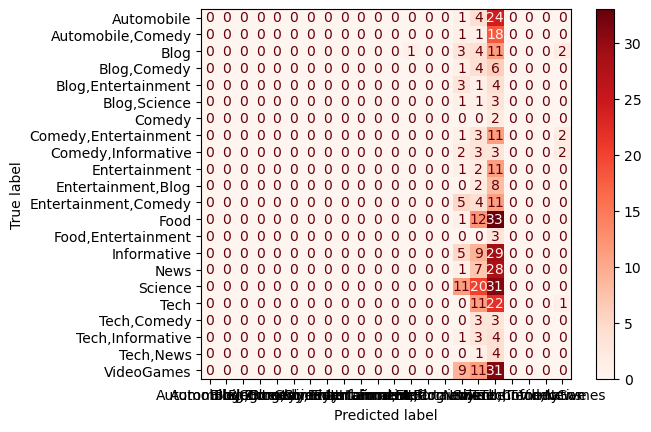

In [88]:
pred = model.predict(x_test)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100, 2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds")

In [89]:
model.save("Inception_0933.h5")

# Grad Cam